In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import *

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import dal
warnings.filterwarnings("ignore")

snow_runner = dal.SnowflakeRunner()

In [3]:
conversations_public = snow_runner.get_data_raw('queries/conversations_public.sql')
df = pd.DataFrame(conversations_public)

In [4]:
project_users = snow_runner.get_data_raw('queries/project_to_staff.sql')
df_project_users = pd.DataFrame(project_users)

In [5]:
dict_cursor_roles = snow_runner.get_data_raw('queries/user_roles.sql')

In [6]:
projects = list(set(df.PROJECT_ID))
list_net = []
for project in  projects:
    user_list = list(set(df[df.PROJECT_ID == project].USER_ID))
    data = list(filter(lambda x: x['PROJECT_ID'] == project, conversations_public))
    roles = list(filter(lambda x: x['USER_ID'] in user_list, dict_cursor_roles))
    list_net.append({'project_id':project, 'network': build_network(data, roles)})

In [7]:
project_centrality = []
for project in projects:
    G = [i for i in filter(lambda x: x['project_id'] == project, list_net)][0]['network']
    centrality_dict = nx.degree_centrality(G)
    centrality_list = [{key:value} for key, value in centrality_dict.items()]
    for i in centrality_list:
        for user, centrality_ in i.items():
            project_centrality.append({'project_id': project, 'user_id': user, 'degree_centrality': centrality_})

In [8]:
df_user_centrality = pd.DataFrame(project_centrality)
df_project_users_filtered = df_project_users[df_project_users.PROJECT_ID.isin(projects)]

In [9]:
project_eigen_centrality = []
for project in projects:
    G = [i for i in filter(lambda x: x['project_id'] == project, list_net)][0]['network']
    if len(G) > 2:
        ec_dict = centrality(G, eigen_vector=True)
        ec_list = [{key:value} for key, value in ec_dict.items()]
        for i in ec_list:
            for user, centrality_ in i.items():
                project_eigen_centrality.append({'project_id': project, 'user_id': user, 'eigen_centrality': centrality_})

In [10]:
df_user_ec = pd.DataFrame(project_eigen_centrality)

In [11]:
df_metrics = df_user_centrality.merge(df_user_ec, right_on=['project_id', 'user_id'], left_on=['project_id', 'user_id'], how = 'left')

In [12]:
df_centrality = df_project_users_filtered.merge(df_metrics, right_on=['project_id', 'user_id'], left_on=['PROJECT_ID', 'USER_ID'], how = 'inner')
df_centrality= df_centrality[pd.notnull(df_centrality.project_id)]
df_centrality = df_centrality[['PROJECT_ID', 'USER_ID', 'degree_centrality', 'eigen_centrality','MAPPING_TYPE']].fillna(0)
df_centrality = df_centrality[df_centrality.MAPPING_TYPE.isin(['Creative', 'Creative Lead'])]

In [13]:
df_centrality['eigen_entropy'] = df_centrality.eigen_centrality*np.log(df_centrality.eigen_centrality)
df_centrality['degree_entropy'] = df_centrality.degree_centrality*np.log(df_centrality.degree_centrality)

In [14]:
df_centrality.eigen_entropy.replace(np.NAN, 0, inplace = True)
df_centrality.degree_entropy.replace(np.NAN, 0, inplace = True)

In [15]:
project_on_time = snow_runner.get_data_raw('queries/project_on_time.sql')
df_project_on_time = pd.DataFrame(project_on_time)

In [16]:
df_creatives_full = df_centrality.merge(df_project_on_time, how = 'left', right_on='PROJECT_ID', left_on='PROJECT_ID')
df_creatives_full_filtered = df_creatives_full[pd.notnull(df_creatives_full.IS_ONTIME)]

In [17]:
df_final = df_creatives_full.groupby(['PROJECT_ID']).agg({'IS_ONTIME':'max', 'degree_centrality':'var',  'degree_entropy':'sum', 'eigen_centrality':'var',  'eigen_entropy':'sum'})
df_final['eigen_entropy'] = - df_final.eigen_entropy

In [18]:
df_nusers = pd.DataFrame(df_project_users.groupby('PROJECT_ID').USER_ID.nunique())
df_nusers.columns = ['n_users']

In [19]:
df_final= df_final.join(df_nusers, how = 'left')

In [20]:
df_final.reset_index().groupby('n_users').PROJECT_ID.nunique()

n_users
2       21
3      137
4      528
5     1032
6      739
7      318
8      145
9       65
10      49
11      32
12       5
13       3
15       1
Name: PROJECT_ID, dtype: int64

In [21]:
df_final = df_final[(df_final.n_users > 3) & (df_final.n_users < 8)]

In [22]:
not_on_time = df_final[df_final.IS_ONTIME == False].eigen_centrality
on_time = df_final[df_final.IS_ONTIME == True].eigen_centrality

{'whiskers': [<matplotlib.lines.Line2D at 0x176c30940>,
 'caps': [<matplotlib.lines.Line2D at 0x176c30430>,
 'boxes': [<matplotlib.lines.Line2D at 0x176c30a00>],
 'medians': [<matplotlib.lines.Line2D at 0x176c30ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x16bb269a0>],
 'means': []}

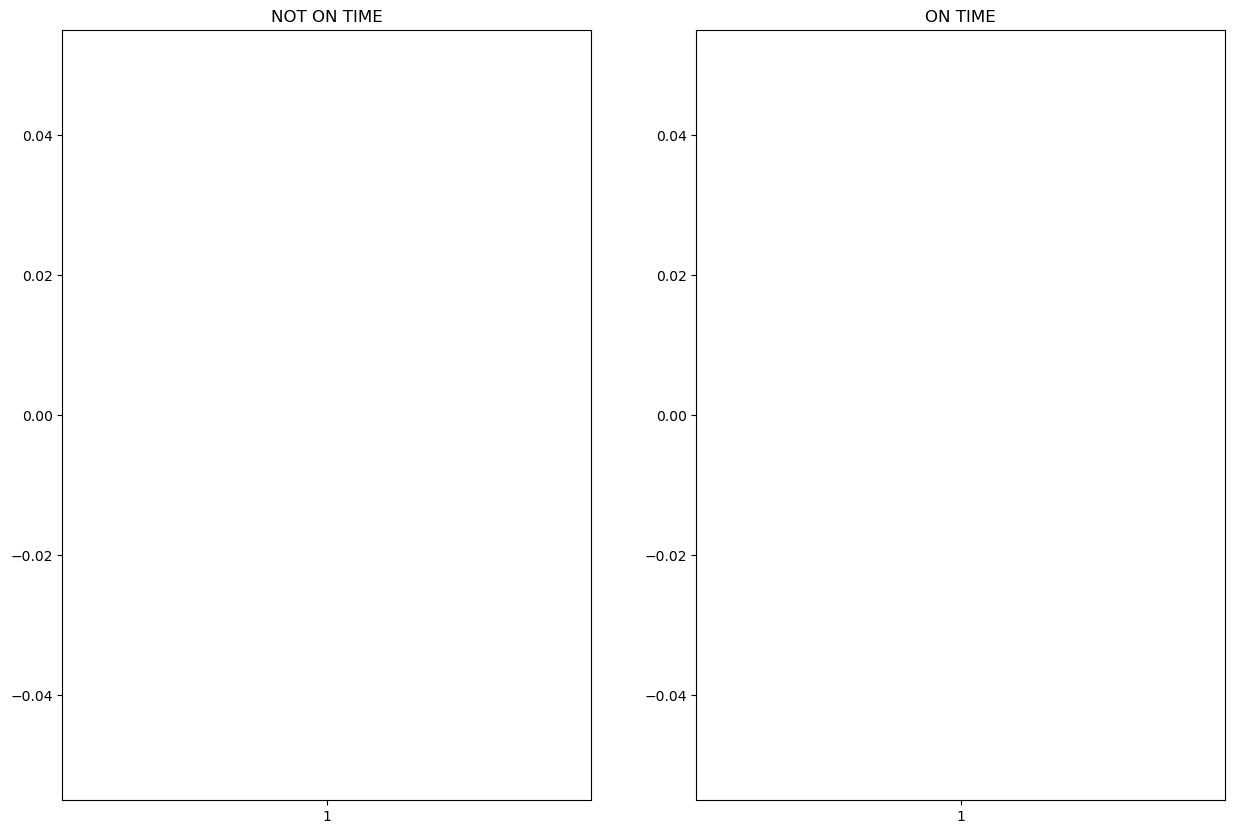

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].set_title('NOT ON TIME')
axes[0].boxplot(not_on_time)
axes[1].set_title('ON TIME')
axes[1].boxplot(on_time)

<AxesSubplot: >

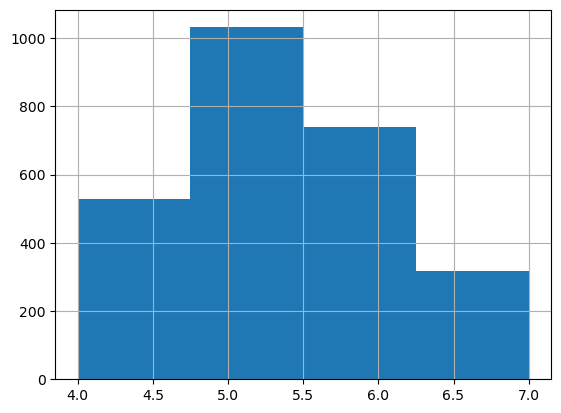

In [24]:
df_final.n_users.hist(bins = 4)

In [25]:
n1 = len(df_final[df_final.IS_ONTIME == True])
n2 = len(df_final[(df_final.IS_ONTIME == False) ])
s1 = np.var(df_final[df_final.IS_ONTIME == True].eigen_entropy)
s2 = np.var(df_final[(df_final.IS_ONTIME == False) ].eigen_entropy)
m1 = df_final[df_final.IS_ONTIME == True].eigen_entropy.mean()
m2 = df_final[(df_final.IS_ONTIME == False) ].eigen_entropy.mean()

In [26]:
significance(n1, n2, s1, s2, m1, m2)

The difference is NOT significant


-0.6506439541861007

In [27]:
s1 = np.var(df_final[df_final.IS_ONTIME == True].n_users)
s2 = np.var(df_final[(df_final.IS_ONTIME == False) ].n_users)
m1 = df_final[df_final.IS_ONTIME == True].n_users.mean()
m2 = df_final[(df_final.IS_ONTIME == False) ].n_users.mean()

In [28]:
significance(n1, n2, s1, s2, m1, m2)

The difference is NOT significant


-0.14309826985690177

In [29]:
df_final.columns = ['IS_ONTIME', 'degree_centrality_var', 'degree_entropy', 'eigen_centrality_var', 'eigen_entropy', 'n_users']

In [30]:
csvs = os.path.abspath(os.path.join('..', 'csvs'))
df_final.reset_index().to_csv(os.path.join(csvs,'creatives.csv'), index=False)